In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', 99999)

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

class Preprocessor:
    def __init__(self, target, train_df, test_df):
        self.target = target
        self.train_df = train_df
        self.test_df = test_df

        self.rare_categories_columns = ["MSSubClass", "MSZoning", "LotShape", "LotConfig", "LandSlope", 
                                            "ExterCond", "RoofStyle", "Foundation", "HeatingQC", "Electrical", 
                                            "BsmtFullBath", "BsmtHalfBath", "HalfBath", "KitchenAbvGr", "Fireplaces", 
                                            "GarageType", "GarageCars", "SaleType", "SaleCondition"]
        self.outliers_columns = ["LotFrontage", "LotArea", "MasVnrArea", "TotalBsmtSF", "1stFlrSF", 
                                                "GrLivArea", "SalePrice"]
        self.columns_to_drop = ["Id", "MiscVal", "Utilities", "Condition2", "YearRemodAdd", "RoofMatl", "Street", 
                              "BsmtFinSF2", "Heating", "Functional", "GarageQual", "GarageCond", "EnclosedPorch", 
                              "LowQualFinSF", "3SsnPorch", "ScreenPorch"]

        self.to_norm_columns_standard = ["LotFrontage", "TotalBsmtSF", "1stFlrSF", 
                                 "GrLivArea", "MoSold"]
        self.to_norm_columns_minmax = ["YrSold", "BedroomAbvGr", "GarageYrBlt", "YearBuilt", "OverallQual", "OverallCond", "TotRmsAbvGrd"]
        
        self.to_norm_non_zeros_column = ["GarageArea", "2ndFlrSF", "BsmtUnfSF", "BsmtFinSF1", "MasVnrArea", 
                                          "WoodDeckSF", "OpenPorchSF"]

        self.to_log_columns = ["LotArea", "GarageArea", "2ndFlrSF", "BsmtUnfSF", "BsmtFinSF1", "MasVnrArea", 
                                          "WoodDeckSF", "OpenPorchSF"]
        
        self.to_encode_columns = ["Fence", "HeatingQC", "BsmtFinType2", "BsmtFinType1", "BsmtQual", 
                                                    "MSSubClass", "MSZoning", "Alley", "LotShape", "LandContour", "LotConfig", 
                                                    "LandSlope", "Neighborhood", "Condition1", "BldgType", "HouseStyle", 
                                                    "RoofStyle", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", 
                                                    "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", 
                                                    "BsmtFinType1", "BsmtFinType2", "HeatingQC", "CentralAir", "Electrical", 
                                                    "BsmtFullBath", "FullBath", "HalfBath", "BsmtHalfBath", "KitchenQual", 
                                                    "Functional", "Fireplaces", "FireplaceQu", "GarageType", "GarageFinish", "PavedDrive", "SaleType", "SaleCondition", "Street"]

    def drop_columns_with_missing_values(self, df, alpha):
        threshold = alpha / 100 * len(df)
        columns_to_drop = df.columns[df.isnull().sum() > threshold]
        df.drop(columns=columns_to_drop, inplace=True)
        return df

    def one_hot_encode_columns(self, df, columns):
        onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
        columns_to_encode = df[self.inter(df.columns, columns)]
        encoded_data = onehot_encoder.fit_transform(columns_to_encode)
        encoded_columns = onehot_encoder.get_feature_names_out(columns_to_encode.columns)
        encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)
        df = df.drop(self.inter(df.columns, columns), axis=1)
        df = pd.concat([df, encoded_df], axis=1)
        return df

    def detect_and_drop_outliers(self, df, columns, iqr_multiplier=2):
        for col in self.inter(columns, df.columns):
            Q1 = df[col].quantile(0.075)
            Q3 = df[col].quantile(0.925)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        return df

    def drop_rare_categories(self, df, columns, max_drop_percentage=0.2):
        for col in columns:
            if col in df.columns:
                freq = df[col].value_counts(normalize=True)
                num_categories_to_examine = int(len(freq) * max_drop_percentage)
                categories_to_examine = freq.tail(num_categories_to_examine).index
                median_freq = freq[~freq.index.isin(categories_to_examine)].median()
                categories_to_drop = [cat for cat in categories_to_examine if freq[cat] < median_freq]
                df = df[~df[col].isin(categories_to_drop)]
        return df

    def normalize_standard(self, df, columns, scaler=None):
        if scaler:
            df[columns] = scaler.transform(df[columns])
        else:
            scaler = StandardScaler()
            df[columns] = scaler.fit_transform(df[columns])
            
        return df, scaler

    def normalize_minmax(self, df, columns, scaler=None):
        if scaler:
            df[columns] = scaler.transform(df[columns])
        else:
            scaler = MinMaxScaler()
            df[columns] = scaler.fit_transform(df[columns])
            
        return df, scaler

    def normalize_target(self, df):
        df[self.target] = StandardScaler().fit_transform(df[[self.target]])
        return df

    def normalize_non_zero(self, df, columns, scaler=None):
        combined_non_zero_mask = (df[columns] != 0).any(axis=1)
        if combined_non_zero_mask.any():
            non_zero_values = df.loc[combined_non_zero_mask, columns]
            if scaler:
                scaled_values = scaler.transform(non_zero_values)
            else:
                scaler = StandardScaler()
                scaled_values = scaler.fit_transform(non_zero_values)
                
            df.loc[combined_non_zero_mask, columns] = scaled_values
        return df, scaler
        
    def log_columns(self, df, columns):
        for col in columns:
            if (df[col] <= -1).any():
                raise ValueError(f"Column '{col}' contains non-positive values. Log transformation cannot be applied.")

        df[columns] = np.log(1 + df[columns])
        return df
        
    def impute_missing_values(self, df, imputer=None):
        numeric_columns = df.select_dtypes(include=['number']).columns
        if imputer:
            imputed_data = imputer.fit_transform(df[numeric_columns])
        else:
            imputer = SimpleImputer(strategy='mean')
            imputed_data = imputer.fit_transform(df[numeric_columns])
            
        df[numeric_columns] = pd.DataFrame(imputed_data, columns=numeric_columns, index=df.index)
        return df, imputer

    def create_features(self, df):
        df["Pool"] = np.where(df["PoolArea"] > 0, 1, 0)
        return df

    def inter(self, cols1, cols2):
        return list(set(cols1).intersection(set(cols2)))

    def without(self, cols1, cols2):
        return list(set(cols1) - set(cols2))

    def drop_entire_columns(self, df):
        pass

    def set_numeric_to_float(self):
        def convert_column_type(column):
            if column.dtype.kind in 'iufc':  # includes int, uint, float, complex
                return column.astype('float64')
            return column
        
        self.train_df = self.train_df.apply(convert_column_type)
        self.test_df = self.test_df.apply(convert_column_type)
    
    def result(self):
        self.set_numeric_to_float()

        self.train_df = self.create_features(self.train_df)
        self.test_df = self.create_features(self.test_df)

        # Drop rows (only for train because we can't drop for test)
        self.train_df = self.detect_and_drop_outliers(self.train_df, self.outliers_columns)
        self.train_df = self.drop_rare_categories(self.train_df, self.rare_categories_columns)

        # Log
        self.train_df = self.log_columns(self.train_df, self.to_log_columns)
        self.test_df = self.log_columns(self.test_df, self.to_log_columns)
        
        # Scale
        self.train_df, normal_scaler = self.normalize_standard(self.train_df, self.to_norm_columns_standard)
        self.train_df, minmax_scaler = self.normalize_minmax(self.train_df, self.to_norm_columns_minmax)
        
        self.train_df, non_zeros_scaler = self.normalize_non_zero(self.train_df, self.to_norm_non_zeros_column)

        self.test_df, _ = self.normalize_standard(self.test_df, self.to_norm_columns_standard, normal_scaler)
        self.test_df, _ = self.normalize_minmax(self.test_df, self.to_norm_columns_minmax, minmax_scaler)
        
        self.test_df, _ = self.normalize_non_zero(self.test_df, self.to_norm_non_zeros_column, non_zeros_scaler)
        
        #self.train_df = self.normalize_target(self.train_df)

        # Impute
        self.train_df, imputer = self.impute_missing_values(self.train_df)
        self.test_df, _ = self.impute_missing_values(self.test_df, imputer)

        # Encode
        self.train_df = self.one_hot_encode_columns(self.train_df, self.to_encode_columns)
        self.test_df = self.one_hot_encode_columns(self.test_df, self.to_encode_columns)
        
        # Drop cols
        self.train_df = self.drop_columns_with_missing_values(self.train_df, 90)
        self.test_df = self.drop_columns_with_missing_values(self.test_df, 90)

        self.train_df = self.train_df.drop(columns=self.inter(self.train_df.columns, self.columns_to_drop))
        self.test_df = self.test_df.drop(columns=self.inter(self.test_df.columns, self.columns_to_drop))

        common_columns = self.inter(self.train_df.columns, self.test_df.columns)
        
        return self.train_df[common_columns + [self.target]], self.test_df[common_columns]

# Assuming train and test DataFrames are already defined
processor = Preprocessor("SalePrice", train, test)

train_processed, test_processed = processor.result()
print(processor.without(train_processed.columns, test_processed.columns))
print(processor.without(test_processed.columns, train_processed.columns))

train_processed

['SalePrice']
[]


,SaleType_ConLD,LotArea,Alley_Pave,HeatingQC_Gd,Neighborhood_Timber,Condition1_Feedr,LotFrontage,Exterior2nd_Stucco,GarageType_BuiltIn,Fence_GdWo,Exterior2nd_VinylSd,MasVnrArea,LandContour_Lvl,MSZoning_RL,SaleCondition_Partial,Functional_Mod,MSSubClass_120.0,FireplaceQu_Gd,Neighborhood_CollgCr,ExterQual_TA,Exterior2nd_Stone,BsmtExposure_nan,Condition1_RRNn,HouseStyle_SFoyer,Exterior2nd_HdBoard,MSSubClass_85.0,Condition1_Norm,BsmtQual_Fa,BldgType_TwnhsE,Functional_Min1,GarageFinish_nan,BsmtFinType1_nan,Functional_Min2,HouseStyle_1Story,MSSubClass_90.0,PoolArea,ExterQual_Gd,LotConfig_FR2,BsmtUnfSF,Fireplaces_1.0,OverallQual,BsmtHalfBath_2.0,HeatingQC_TA,Exterior2nd_Plywood,Neighborhood_NAmes,FullBath_1.0,Neighborhood_Veenker,Neighborhood_Sawyer,SaleType_ConLI,TotRmsAbvGrd,Exterior2nd_Wd Sdng,Neighborhood_BrDale,BsmtFinType1_Unf,BsmtFinType2_LwQ,BsmtFinType1_GLQ,BsmtHalfBath_1.0,LotShape_IR3,Street_Pave,LandSlope_Mod,ExterCond_Fa,FullBath_2.0,Functional_Typ,YearBuilt,LotConfig_CulDSac,Exterior2nd_Brk Cmn,Neighborhood_SWISU,Exterior1st_Plywood,Exterior2nd_CmentBd,Neighborhood_Somerst,MSSubClass_80.0,Exterior2nd_Wd Shng,TotalBsmtSF,LotShape_IR2,Neighborhood_StoneBr,BsmtExposure_Mn,Exterior1st_HdBoard,BsmtFinType2_Rec,FullBath_3.0,SaleType_Oth,Neighborhood_Edwards,Neighborhood_NWAmes,HalfBath_1.0,Neighborhood_NoRidge,KitchenQual_Fa,Functional_Maj2,Neighborhood_Blueste,Pool,Fireplaces_2.0,Exterior1st_BrkComm,GrLivArea,LotShape_Reg,Neighborhood_Mitchel,SaleCondition_Alloca,BsmtFinType2_BLQ,BsmtFinType2_nan,BsmtCond_TA,Neighborhood_NridgHt,Fireplaces_3.0,GarageType_CarPort,Foundation_Slab,Exterior1st_WdShing,KitchenQual_Gd,OpenPorchSF,Neighborhood_BrkSide,WoodDeckSF,Exterior1st_Stucco,1stFlrSF,KitchenAbvGr,Alley_nan,Condition1_RRNe,MSZoning_RM,HeatingQC_Fa,Electrical_FuseP,Neighborhood_NPkVill,MasVnrType_BrkFace,FireplaceQu_Fa,GarageType_nan,ExterCond_Gd,SaleType_WD,Fence_nan,BsmtFullBath_2.0,Fence_MnWw,Exterior2nd_BrkFace,BsmtFinSF1,BsmtFinType1_BLQ,LandSlope_Sev,Exterior2nd_ImStucc,BsmtFullBath_3.0,GarageYrBlt,GarageArea,Neighborhood_SawyerW,RoofStyle_Hip,GarageFinish_Unf,FireplaceQu_nan,Neighborhood_Crawfor,BsmtFinType1_LwQ,HalfBath_2.0,HouseStyle_1.5Unf,RoofStyle_Gambrel,KitchenQual_TA,MSSubClass_50.0,BsmtExposure_Gd,YrSold,Neighborhood_ClearCr,SaleType_CWD,FireplaceQu_TA,OverallCond,Neighborhood_OldTown,MSSubClass_190.0,Electrical_FuseF,LotConfig_Inside,Exterior1st_AsphShn,Neighborhood_Gilbert,MSSubClass_70.0,Neighborhood_IDOTRR,HouseStyle_2Story,BldgType_Duplex,LandContour_HLS,Condition1_RRAe,Electrical_SBrkr,MSSubClass_30.0,BsmtCond_nan,BsmtExposure_No,LandContour_Low,HouseStyle_2.5Unf,SaleType_New,MasVnrType_nan,BldgType_Twnhs,BsmtFinType1_Rec,Condition1_PosN,Fence_MnPrv,MSSubClass_75.0,BsmtFinType2_GLQ,SaleCondition_Normal,GarageType_Basment,HouseStyle_SLvl,BsmtCond_Gd,Neighborhood_MeadowV,BsmtQual_TA,Exterior2nd_MetalSd,ExterCond_TA,BsmtFinType2_Unf,BsmtFullBath_1.0,PavedDrive_P,SaleCondition_Family,Foundation_PConc,Foundation_Stone,GarageCars,RoofStyle_Mansard,MoSold,Foundation_CBlock,BsmtQual_nan,MSSubClass_60.0,SaleType_ConLw,Exterior1st_VinylSd,GarageType_Detchd,Exterior1st_CBlock,Exterior1st_BrkFace,GarageFinish_RFn,FireplaceQu_Po,Condition1_PosA,Condition1_RRAn,Exterior2nd_CBlock,BedroomAbvGr,BldgType_2fmCon,BsmtQual_Gd,2ndFlrSF,MSZoning_RH,MasVnrType_Stone,MSSubClass_160.0,CentralAir_Y,Exterior1st_MetalSd,Exterior1st_Wd Sdng,PavedDrive_Y,ExterQual_Fa,Exterior2nd_AsphShn,Exterior1st_CemntBd,SalePrice
0,0.0,9.042040,0.0,0.0,0.0,0.0,-0.231990,0.0,0.0,0.0,1.0,1.209078,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.409051,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.949275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.484210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.415387,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.844305,0.0,-0.948258,0.0,-0.829030,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.

[I 2024-07-24 19:51:59,949] A new study created in memory with name: no-name-3a47d5ff-f33c-40fa-a43f-c06f2a6e8ff7
Optuna Progress:  98%|▉| 49/50 [17:04<00:47, 47.25s/it, Best RMSLE=0.1141, [I 2024-07-24 20:09:31,116] Trial 49 finished with value: 0.12436415757813521 and parameters: {'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.1357058641583988, 'subsample': 0.6557055990498083, 'colsample_bytree': 0.7812535321051602, 'gamma': 0.15619354397766655, 'min_child_weight': 1, 'reg_alpha': 0.028167141700663468, 'reg_lambda': 0.601221419081086, 'n_features_to_select': 116}. Best is trial 47 with value: 0.11411796524694644.
Optuna Progress: 100%|█| 50/50 [17:31<00:00, 21.02s/it, Best RMSLE=0.1141, 


Meilleurs paramètres trouvés :  {'n_estimators': 338, 'max_depth': 3, 'learning_rate': 0.09911393852882915, 'subsample': 0.6267629467005082, 'colsample_bytree': 0.7674971912507891, 'gamma': 0.173287877718446, 'min_child_weight': 1, 'reg_alpha': 0.045310455325460144, 'reg_lambda': 0.5037753791288415, 'n_features_to_select': 132}
Meilleur score :  0.11411796524694644
Mean Squared Error (MSE): 56686470.7637
Root Mean Squared Error (RMSE): 7529.0418
Mean Absolute Error (MAE): 5801.2172
R^2 Score: 0.9906
Root Mean Squared Log Error (RMSLE): 0.0523


<Figure size 2500x2000 with 0 Axes>

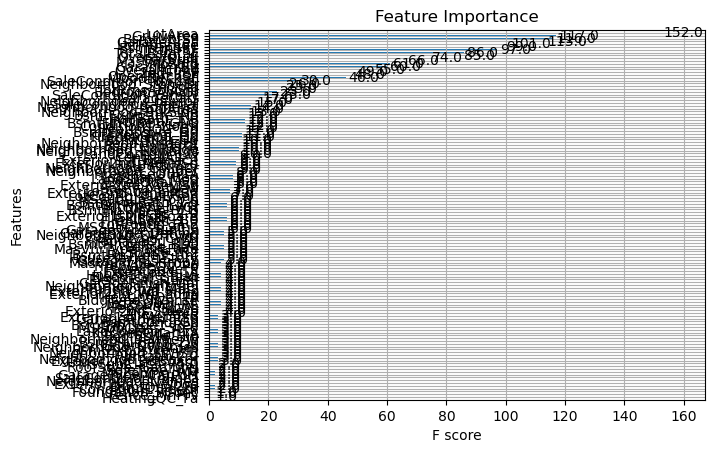

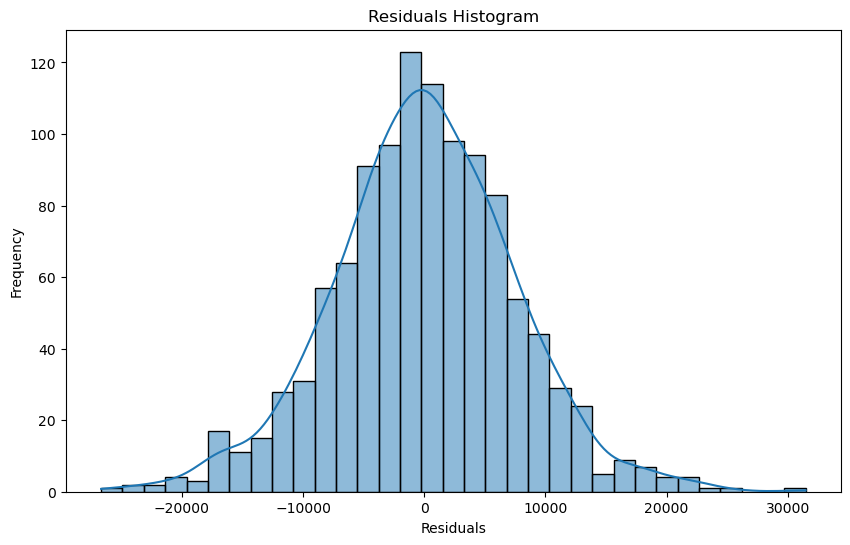

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, make_scorer, root_mean_squared_log_error
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor, plot_importance
import optuna
from tqdm import tqdm

class XGBoostModelTuner:
    def __init__(self, train_df, test_df, target):
        self.train_df = train_df
        self.test_df = test_df
        self.target = target
        self.model = XGBRegressor()
        self.results = {}
        self.best_score = float("inf")

    def prepare_data(self):
        X = self.train_df.drop(self.target, axis=1)
        y = self.train_df[self.target]
        self.X_train, self.y_train = X, y

    def tune_model(self, max_evals=50):
        self.prepare_data()

        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 400),
                'max_depth': trial.suggest_int('max_depth', 3, 9),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 0.0, 0.2),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 1, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 1.5)
            }

            n_features_to_select = trial.suggest_int('n_features_to_select', 5, self.X_train.shape[1])

            model = XGBRegressor(**params)
            selector = RFE(model, n_features_to_select=n_features_to_select, step=1)
            selector = selector.fit(self.X_train, self.y_train)
            selected_features = self.X_train.columns[selector.support_]

            # Cross-validation
            cv_scores = cross_val_score(
                model,
                self.X_train[selected_features],
                self.y_train,
                cv=5,  # Number of cross-validation folds
                scoring=make_scorer(root_mean_squared_log_error, greater_is_better=False)
            )

            # Average of the cross-validated scores
            score = -np.mean(cv_scores)  # Negate because cross_val_score returns negative values for regression metrics

            self.best_score = min(self.best_score, score)

            trial.set_user_attr("n_features_to_select", n_features_to_select)
            trial.set_user_attr("current_score", score)

            return score

        study = optuna.create_study(direction='minimize')
        
        pbar = tqdm(total=max_evals, desc="Optuna Progress")
        def callback(study, trial):
            pbar.set_postfix({
                "Best RMSLE": f"{study.best_value:.4f}",
                "Current Score": f"{trial.user_attrs['current_score']:.4f}",
                "Best Features": f"{trial.user_attrs['n_features_to_select']}"
            })
            pbar.update(1)

        study.optimize(objective, n_trials=max_evals, callbacks=[callback])
        pbar.close()

        best_params = study.best_params
        self.results['best_params'] = best_params

        self.model = XGBRegressor(**{k: v for k, v in best_params.items() if k != 'n_features_to_select'})
        n_features_to_select = best_params['n_features_to_select']
        selector = RFE(self.model, n_features_to_select=n_features_to_select, step=1)
        selector = selector.fit(self.X_train, self.y_train)
        self.selected_features = self.X_train.columns[selector.support_]

        self.model.fit(self.X_train[self.selected_features], self.y_train)
        
        print("Meilleurs paramètres trouvés : ", best_params)
        print("Meilleur score : ", self.best_score)

    def evaluate_model(self):
        y_pred = self.model.predict(self.X_train[self.selected_features])
        mse = mean_squared_error(self.y_train, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_train, y_pred)
        r2 = r2_score(self.y_train, y_pred)
        rmsle = root_mean_squared_error(np.log1p(self.y_train), np.log1p(y_pred))

        self.results['test_mse'] = mse
        self.results['test_rmse'] = rmse
        self.results['test_mae'] = mae
        self.results['r2_score'] = r2
        self.results['rmsle'] = rmsle

        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R^2 Score: {r2:.4f}")
        print(f"Root Mean Squared Log Error (RMSLE): {rmsle:.4f}")

    def plot_feature_importance(self):
        plt.figure(figsize=(25, 20))
        plot_importance(self.model, importance_type='weight')
        plt.title('Feature Importance')
        plt.show()

    def plot_residuals(self):
        y_pred = self.model.predict(self.X_train[self.selected_features])
        residuals = self.y_train - y_pred
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True)
        plt.title('Residuals Histogram')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()
        self.residuals = residuals

    def run(self):
        self.tune_model()
        self.evaluate_model()
        self.plot_feature_importance()
        self.plot_residuals()

    def predict(self):
        predictions = self.model.predict(self.test_df[self.selected_features])
        return predictions

def predict_save(tuner):
    predictions = tuner.predict()
    submission = pd.read_csv("sample_submission.csv")
    submission["SalePrice"] = predictions

    if 'Unnamed: 0' in submission.columns:
        submission.drop(columns=['Unnamed: 0'], inplace=True)

    submission.to_csv("sample_submission.csv", index=False)

tuner_XGB = XGBoostModelTuner(train_processed, test_processed, 'SalePrice')
tuner_XGB.run()
predict_save(tuner_XGB)


# LightGBM

Hyperopt Progress: 100%|█████████████████| 100/100 [00:10<00:00,  9.55it/s]


Meilleurs paramètres trouvés :  {'colsample_bytree': 0.857506569794472, 'learning_rate': 0.36563448726530695, 'max_depth': 4, 'min_child_samples': 10, 'min_split_gain': 0.18258914806321708, 'n_estimators': 300, 'num_leaves': 120, 'reg_alpha': 0.13809362924383484, 'reg_lambda': 0.7934526320044069, 'subsample': 0.6211611332897052}
Meilleur score :  0.1359512285952352
Mean Squared Error (MSE): 708174897.0689
Root Mean Squared Error (RMSE): 26611.5557
Mean Absolute Error (MAE): 17897.3966
R^2 Score: 0.8808


<Figure size 1000x800 with 0 Axes>

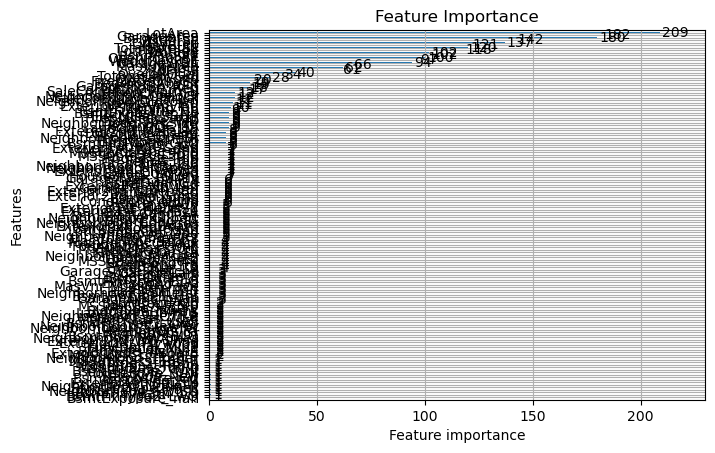

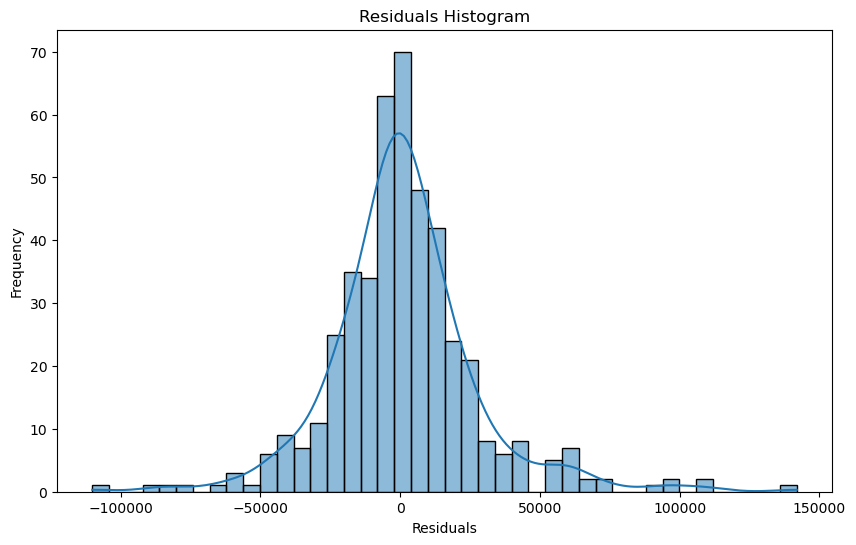

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import ParameterGrid
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from tqdm import tqdm

class LightGBMModelTuner:
    def __init__(self, train_df, test_df, target):
        """
        Initialise l'objet LightGBMModelTuner avec les DataFrames prétraités et le nom de la colonne cible.

        Paramètres:
        train_df (pd.DataFrame): Le DataFrame contenant les données d'entraînement.
        test_df (pd.DataFrame): Le DataFrame contenant les données de test.
        target (str): Le nom de la colonne cible.
        """
        self.train_df = train_df
        self.test_df = test_df
        self.target = target
        self.model = LGBMRegressor(verbose=-1)
        self.results = {}

    def prepare_data(self):
        """
        Prépare les données pour l'entraînement et le test.
        """
        X = self.train_df.drop(self.target, axis=1)
        y = self.train_df[self.target]
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.4, random_state=42)

    def tune_model(self):
        """
        Effectue la fine-tuning du modèle LightGBM en utilisant une recherche de grille personnalisée.
        """
        self.prepare_data()
        
        param_grid = {
            'n_estimators': [200, 500, 600],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.7, 1],
            'colsample_bytree': [0.7, 1],
            'min_child_samples': [10, 20, 30],
            'reg_alpha': [0, 0.1, 0.25],
            'reg_lambda': [0.5, 1]
        }
    
        param_list = list(ParameterGrid(param_grid))
        best_score = float('inf')
        best_params = None
        total_iterations = len(param_list)
        
        # Utiliser tqdm pour afficher la barre de progression
        pbar = tqdm(total=total_iterations, desc="Grid Search Progress")
    
        for i, params in enumerate(param_list):
            self.model.set_params(**params)
            self.model.fit(self.X_train, self.y_train)
            preds = self.model.predict(self.X_val)
            score = root_mean_squared_error(np.log(self.y_val), np.log(preds))
    
            if score < best_score:
                best_score = score
                best_params = params
            
            # Mettre à jour la barre de progression et afficher les scores en temps réel
            pbar.set_postfix({
                'Current score': f'{score:.4f}', 
                'Best score': f'{best_score:.4f}',
                'Iteration': f'{i+1}/{total_iterations}'
            })
            pbar.update(1)
        
        pbar.close()
    
        self.results['best_params'] = best_params
        
        # Calculer la meilleure MSE obtenue
        self.model = LGBMRegressor(**best_params, verbose=-1)
        self.model.fit(self.X_train, self.y_train)
        best_preds = self.model.predict(self.X_val)
        best_score = root_mean_squared_error(np.log(self.y_val), np.log(best_preds))
        
        print("Meilleurs paramètres trouvés : ", best_params)
        print("Meilleur score : ", best_score)

    def tune_model_grad(self, max_evals=100):
        """
        Effectue la fine-tuning du modèle LightGBM en utilisant l'optimisation bayésienne avec hyperopt.
    
        Parameters:
        max_evals (int): Le nombre maximal d'évaluations à effectuer pour trouver les meilleurs hyperparamètres.
        """
        self.prepare_data()
        
        def objective(params):
            model = LGBMRegressor(**params, verbose=-1)
            model.fit(self.X_train, self.y_train)
            preds = model.predict(self.X_val)
            score = root_mean_squared_error(np.log(self.y_val), np.log(preds))
            return {'loss': score, 'status': STATUS_OK}
        
        param_space = {
            'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 50)),
            'max_depth': scope.int(hp.quniform('max_depth', 3, 9, 1)),
            'learning_rate': hp.loguniform('learning_rate', -5, -1),
            'subsample': hp.uniform('subsample', 0.6, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
            'min_child_samples': scope.int(hp.quniform('min_child_samples', 5, 50, 5)),
            'reg_alpha': hp.loguniform('reg_alpha', -3, 0),
            'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
            'num_leaves': scope.int(hp.quniform('num_leaves', 20, 150, 5)),
            'min_split_gain': hp.uniform('min_split_gain', 0.0, 1.0)
        }
                
        trials = Trials()
        
        # Utiliser tqdm pour afficher la barre de progression
        with tqdm(total=max_evals, desc="Hyperopt Progress") as pbar:
            for i in range(max_evals):
                # Ajuster le learning rate après chaque itération
                if i > 0:
                    learning_rate_values = [trial['misc']['vals']['learning_rate'][0] for trial in trials.trials]
                    mean_learning_rate = sum(learning_rate_values) / len(learning_rate_values)
                    param_space['learning_rate'] = hp.loguniform('learning_rate', -5, -1) * mean_learning_rate
    
                fmin(fn=objective,
                     space=param_space,
                     algo=tpe.suggest,
                     max_evals=len(trials.trials) + 1,
                     trials=trials,
                     show_progressbar=False)  # Désactiver la barre de progression par défaut de fmin
                pbar.update(1)
        
        # Obtenir les meilleurs paramètres trouvés par hyperopt
        best = trials.best_trial['result']['loss']
        
        # Obtenir les paramètres associés au meilleur essai
        best_params = {key: int(trials.best_trial['misc']['vals'][key][0]) if key in ['n_estimators', 'max_depth', 'min_child_samples', 'num_leaves'] else trials.best_trial['misc']['vals'][key][0] for key in trials.best_trial['misc']['vals']}
        
        self.results['best_params'] = best_params
        
        # Calculer la meilleure MSE obtenue
        self.model = LGBMRegressor(**best_params, verbose=-1)
        self.model.fit(self.X_train, self.y_train)
        
        best_preds = self.model.predict(self.X_val)
        best_score = root_mean_squared_error(np.log(self.y_val), np.log(best_preds))
        
        print("Meilleurs paramètres trouvés : ", best_params)
        print("Meilleur score : ", best_score)
    
    def evaluate_model(self):
        """
        Évalue le modèle sur l'ensemble de validation et enregistre les statistiques.
        """
        y_pred = self.model.predict(self.X_val)
        mse = mean_squared_error(self.y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_val, y_pred)
        r2 = r2_score(self.y_val, y_pred)

        self.results['test_mse'] = mse
        self.results['test_rmse'] = rmse
        self.results['test_mae'] = mae
        self.results['r2_score'] = r2

        # Print statistics
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R^2 Score: {r2:.4f}")

    def plot_feature_importance(self):
        """
        Affiche les importances des caractéristiques du modèle LightGBM.
        """
        plt.figure(figsize=(10, 8))
        plot_importance(self.model, importance_type='split')
        plt.title('Feature Importance')
        plt.show()

    def plot_residuals(self):
        """
        Affiche le graphique des résidus.
        """
        y_pred = self.model.predict(self.X_val)
        residuals = self.y_val - y_pred
        self.residuals = residuals
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True)
        plt.title('Residuals Histogram')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()

    def run(self):
        """
        Exécute les étapes de fine-tuning, d'entraînement, d'évaluation et de génération des graphiques.
        """
        self.tune_model_grad()
        self.evaluate_model()
        self.plot_feature_importance()
        self.plot_residuals()

    def predict(self):
        """
        Prédit les valeurs cibles pour les données de test en utilisant le modèle entraîné.
    
        Retourne:
        np.ndarray: Les prédictions du modèle.
        """
        predictions = self.model.predict(self.test_df)
        return predictions

tuner_LGBM = LightGBMModelTuner(train_processed, test_processed, 'SalePrice')
tuner_LGBM.run()
predict_save(tuner_LGBM)

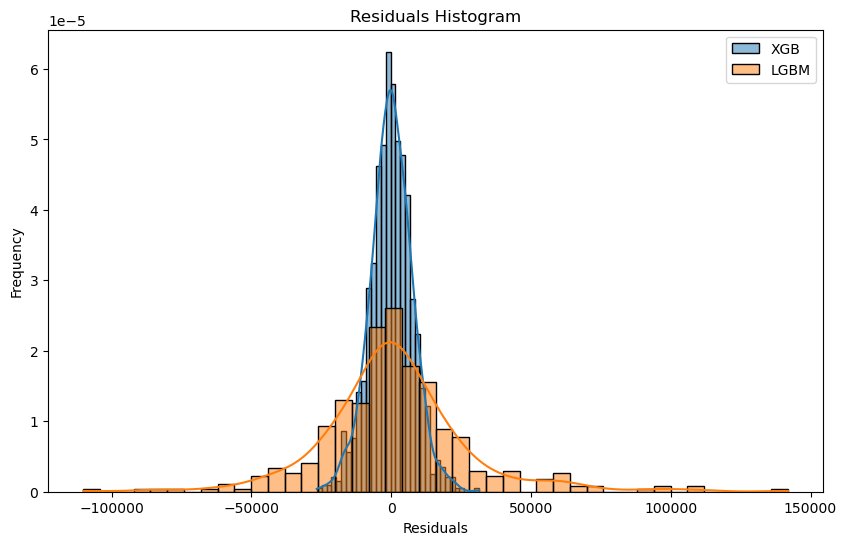

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(tuner_XGB.residuals, kde=True, alpha=0.5, label="XGB", stat='density')
sns.histplot(tuner_LGBM.residuals, kde=True, alpha=0.5, label="LGBM", stat='density')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()